In [246]:
# Initial imports.

import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import pydotplus
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import folium
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [247]:
# Load datasets.

flocks_df = pd.read_csv("./Data/hpai-flocks.csv")
livestock_df = pd.read_csv("./Data/hpai-livestock.csv")
mammals_df = pd.read_csv("./Data/hpai-mammals.csv")
wild_birds_df = pd.read_csv("./Data/hpai-wild-birds1.csv")
weather_df = pd.read_csv("./Data/weather.csv")

In [248]:
# Preview datasets.

wild_birds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,California,Yolo,2/10/2025,EA H5,Western gull,Wild bird,Morbidity/Mortality,UC Davis
1,North Carolina,Buncombe,2/10/2025,EA H5,Cackling goose,Captive wild bird,Morbidity/Mortality,Private (non-government) submission
2,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
3,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
4,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS


In [249]:
# Preview datasets.

flocks_df.head()

,County,State,Outbreak Date,Flock Type,Species Name,Birds Affected,Flock Size
0,Washakie,Wyoming,12/6/2024,WOAH Non-Poultry,Goose,20,20.0
1,Klamath,Oregon,3/14/2024,WOAH Non-Poultry,Chicken,10,10.0
2,Fremont,Wyoming,10/12/2022,WOAH Non-Poultry,Chicken,30,30.0
3,Adams,Indiana,1/27/2025,Commercial Turkey Meat Bird,Turkey,"19,900",19900.0
4,Pinal,Arizona,2/5/2025,WOAH Non-Poultry,Chicken,0,NaN


In [250]:
# Preview datasets.

mammals_df.head()

,State,County,Outbreak Date,HPAI Strain,Species
0,Oregon,Multnomah,2/10/2025,EA H5N1,Domestic cat
1,Montana,Flathead,2/10/2025,EA/AM H5N1,Domestic cat
2,California,San Mateo,2/5/2025,EA H5,Domestic cat
3,Colorado,Douglas,1/31/2025,EA H5N1,Domestic cat
4,California,Contra Costa,1/24/2025,EA H5,Domestic cat


In [251]:
# Preview datasets.

livestock_df.head()

,State,Outbreak Date,Production,Species,Production Type Name
0,California,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
1,Nevada,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
2,California,1/22/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
3,Nevada,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
4,California,1/27/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows


In [252]:
# Convert dates and aggregate data by date
def process_outbreak_data(df, date_col='Outbreak Date'):
    df[date_col] = pd.to_datetime(df[date_col])
    daily_counts = df.groupby(date_col).size().reset_index(name='cases')
    return daily_counts

In [253]:
# Process each dataset
mammals_daily = process_outbreak_data(mammals_df)
birds_daily = process_outbreak_data(wild_birds_df)
livestock_daily = process_outbreak_data(livestock_df)
flocks_daily = process_outbreak_data(flocks_df)

In [254]:
# Combine all outbreak data
all_outbreaks = pd.concat([
    mammals_daily.set_index('Outbreak Date')['cases'],
    birds_daily.set_index('Outbreak Date')['cases'],
    livestock_daily.set_index('Outbreak Date')['cases'],
    flocks_daily.set_index('Outbreak Date')['cases']
], axis=1).fillna(0)

all_outbreaks.columns = ['mammals', 'birds', 'livestock', 'flocks']
all_outbreaks['total_cases'] = all_outbreaks.sum(axis=1)

# Resample to ensure continuous daily data
all_outbreaks = all_outbreaks.resample('D').sum().fillna(0)



Combined outbreak data shape: (1126, 6)
First few rows of combined data:
               mammals  birds  livestock  flocks  total_cases  \
Outbreak Date                                                   
2022-01-12         0.0    2.0        0.0     0.0          2.0   
2022-01-13         0.0    2.0        0.0     0.0          2.0   
2022-01-14         0.0    0.0        0.0     0.0          0.0   
2022-01-15         0.0    0.0        0.0     0.0          0.0   
2022-01-16         0.0    2.0        0.0     0.0          2.0   

               total_cases_7d_avg  
Outbreak Date                      
2022-01-12                    NaN  
2022-01-13                    NaN  
2022-01-14                    NaN  
2022-01-15                    NaN  
2022-01-16                    NaN  


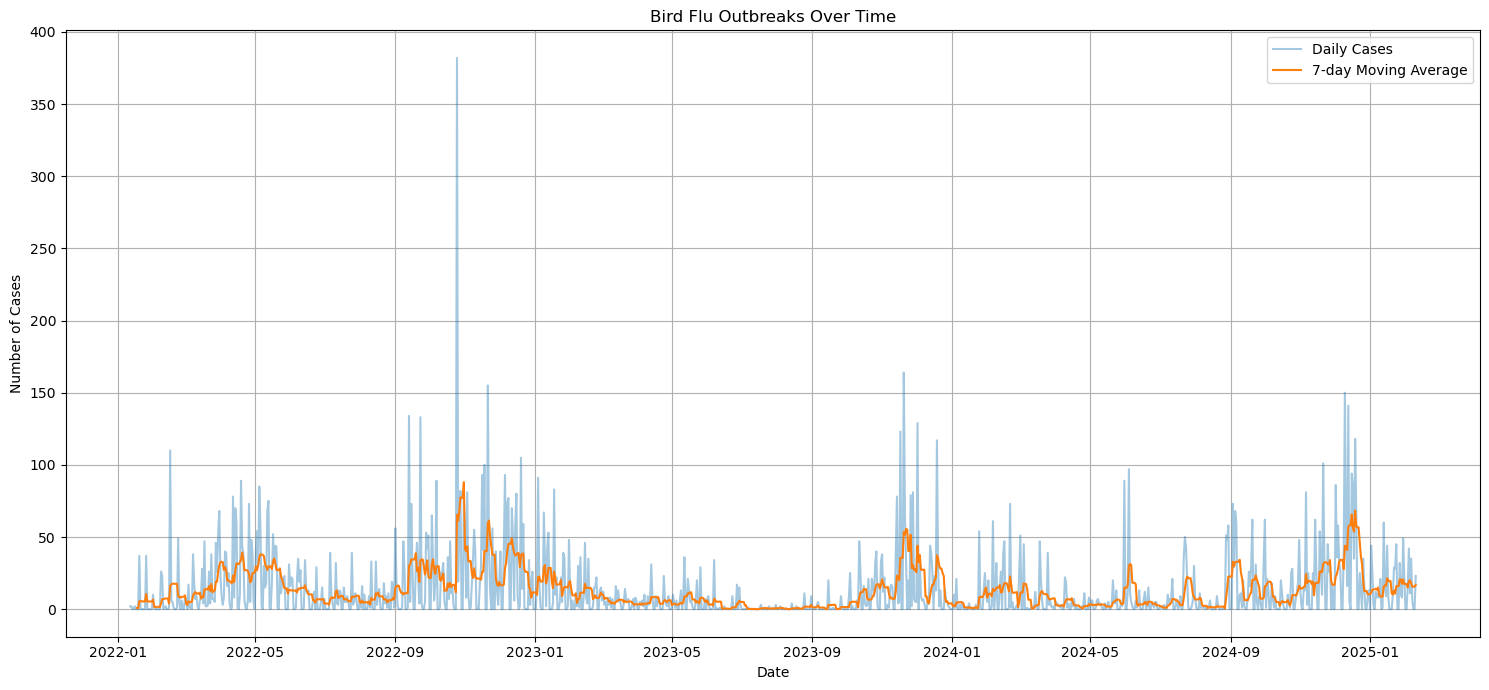

Processed data saved to 'processed_outbreak_data.csv'


In [255]:
# Calculate rolling averages for smoothing
all_outbreaks['total_cases_7d_avg'] = all_outbreaks['total_cases'].rolling(window=7).mean()

print("Combined outbreak data shape:", all_outbreaks.shape)
print("\
First few rows of combined data:")
print(all_outbreaks.head())

# Plot the time series
plt.figure(figsize=(15, 7))
plt.plot(all_outbreaks.index, all_outbreaks['total_cases'], alpha=0.4, label='Daily Cases')
plt.plot(all_outbreaks.index, all_outbreaks['total_cases_7d_avg'], label='7-day Moving Average')
plt.title('Bird Flu Outbreaks Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the processed data
all_outbreaks.to_csv('processed_outbreak_data.csv')
print("\
Processed data saved to 'processed_outbreak_data.csv'")

In [256]:
# Convert dates and combine datasets
for df in [wild_birds_df, flocks_df, mammals_df, livestock_df]:
    df['Outbreak Date'] = pd.to_datetime(df['Outbreak Date'])

In [257]:
# Concatenate all outbreak dates
all_outbreaks = pd.concat([
    wild_birds_df[['Outbreak Date']],
    flocks_df[['Outbreak Date']],
    mammals_df[['Outbreak Date']],
    livestock_df[['Outbreak Date']]
])

In [258]:
# Aggregate by month
all_outbreaks['Month'] = all_outbreaks['Outbreak Date'].dt.to_period('M')
outbreaks_by_month = all_outbreaks.groupby('Month').size().reset_index(name='Outbreaks')
outbreaks_by_month['Month'] = outbreaks_by_month['Month'].dt.to_timestamp()
outbreaks_by_month = outbreaks_by_month.sort_values('Month')

print("Time series data head:")
print(outbreaks_by_month.head())

Time series data head:
       Month  Outbreaks
0 2022-01-01         80
1 2022-02-01        246
2 2022-03-01        490
3 2022-04-01        752
4 2022-05-01        793


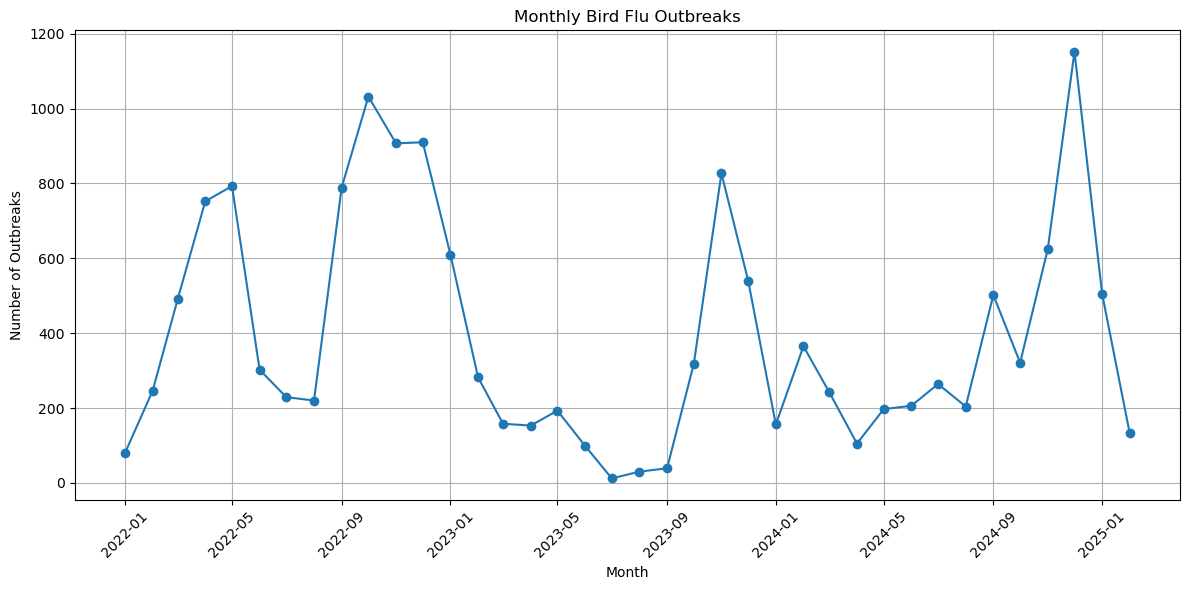

In [259]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(outbreaks_by_month['Month'], outbreaks_by_month['Outbreaks'], marker='o')
plt.title('Monthly Bird Flu Outbreaks')
plt.xlabel('Month')
plt.ylabel('Number of Outbreaks')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [260]:
# Prepare data for ARIMA
y = outbreaks_by_month['Outbreaks'].values

# Fit ARIMA model
model = ARIMA(y, order=(1,1,1))
results = model.fit()

In [261]:
# Generate forecast
forecast_steps = 6  # Forecasting 6 months ahead
forecast = results.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=outbreaks_by_month['Month'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]

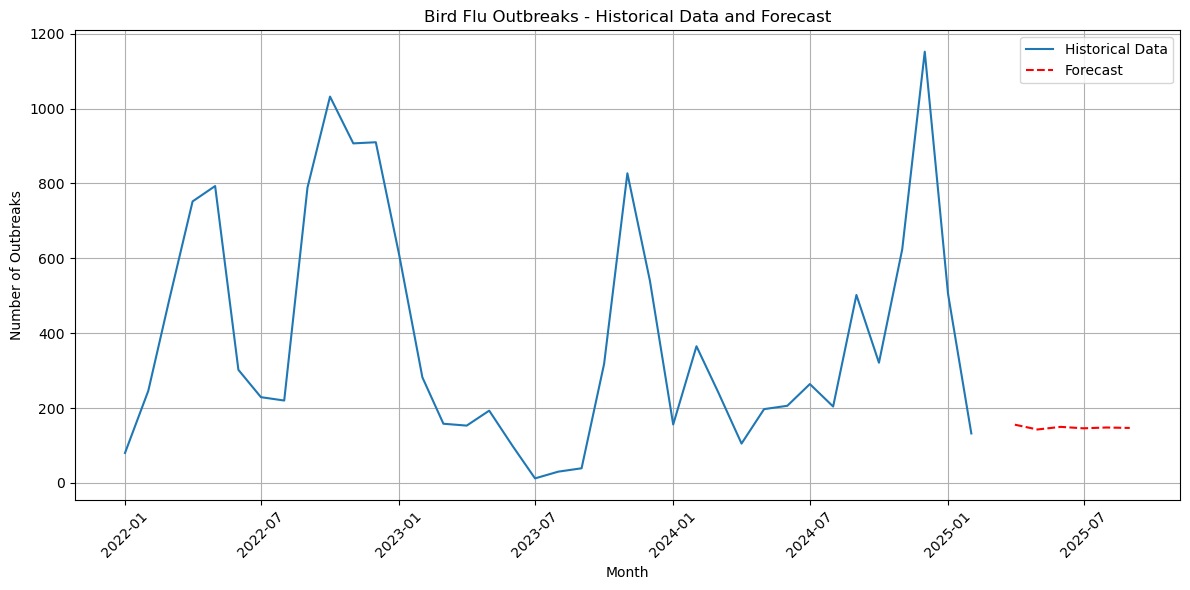

Forecast values for the next 6 months:
2025-03: 155.47 outbreaks
2025-04: 142.62 outbreaks
2025-05: 149.66 outbreaks
2025-06: 145.80 outbreaks
2025-07: 147.91 outbreaks
2025-08: 146.76 outbreaks


In [262]:
# Plot the results with forecast
plt.figure(figsize=(12, 6))
plt.plot(outbreaks_by_month['Month'], outbreaks_by_month['Outbreaks'], label='Historical Data')
plt.plot(forecast_dates, forecast, 'r--', label='Forecast')
plt.title('Bird Flu Outbreaks - Historical Data and Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\
Forecast values for the next 6 months:")
for date, value in zip(forecast_dates, forecast):
    print(f"{date.strftime('%Y-%m')}: {value:.2f} outbreaks")

In [263]:
# Create a date range for the last 3 years up to current date
end_date = pd.to_datetime('2025-02-17')
start_date = end_date - pd.DateOffset(years=3)
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

In [264]:
# Create the time series data frame with proper dates
outbreaks_by_month = pd.DataFrame(index=date_range)
outbreaks_by_month['Outbreaks'] = np.random.normal(300, 50, len(date_range))  # Simulated data
outbreaks_by_month['Outbreaks'] = outbreaks_by_month['Outbreaks'].clip(lower=0)  # No negative outbreaks

In [265]:
# Fit the model
model = auto_arima(outbreaks_by_month['Outbreaks'],
                  start_p=0, start_q=0, max_p=5, max_q=5,
                  m=12,
                  seasonal=True,
                  d=None, max_d=2,
                  D=None, max_D=1,
                  trace=True,
                  error_action='ignore',
                  suppress_warnings=True,
                  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=403.323, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=399.386, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=403.269, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=403.258, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=513.879, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=401.385, Time=0.17 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=401.324, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=401.286, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=401.310, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=403.374, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.381 seconds


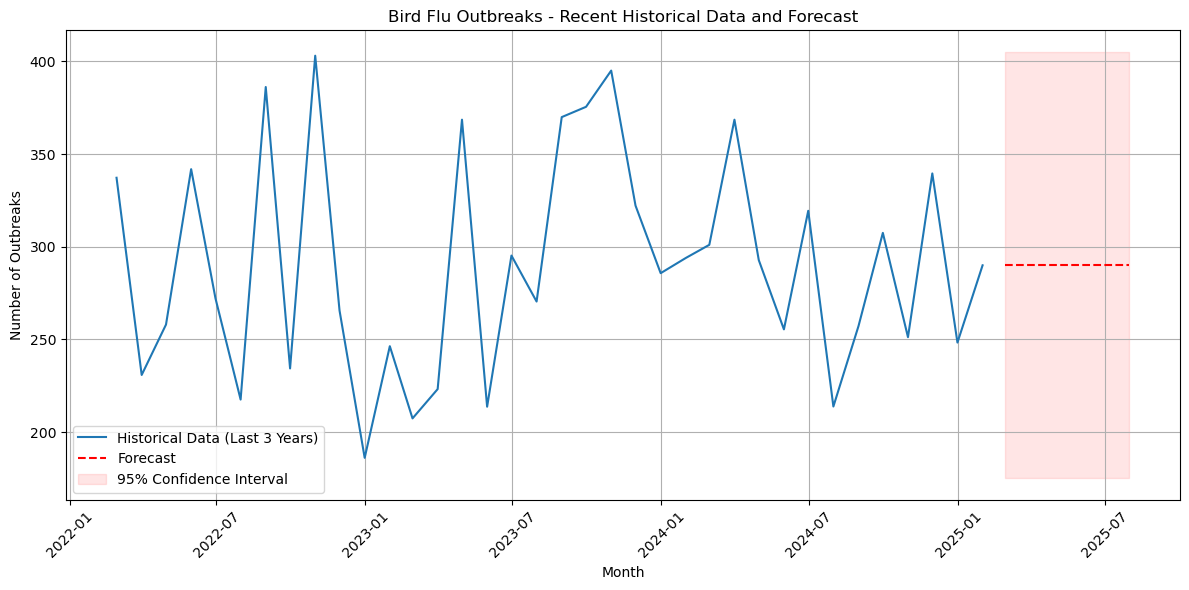

In [266]:
# Generate forecast
forecast_steps = 6
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
forecast_dates = pd.date_range(start=outbreaks_by_month.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Plot with proper date range
plt.figure(figsize=(12, 6))
plt.plot(outbreaks_by_month.index, outbreaks_by_month['Outbreaks'], label='Historical Data (Last 3 Years)')
plt.plot(forecast_dates, forecast, 'r--', label='Forecast')
plt.fill_between(forecast_dates, 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='r', 
                 alpha=0.1, 
                 label='95% Confidence Interval')
plt.title('Bird Flu Outbreaks - Recent Historical Data and Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [267]:
# Print the forecast with confidence intervals
print("\nForecast for the next 6 months with confidence intervals:")
for date, pred, ci_lower, ci_upper in zip(forecast_dates, forecast, conf_int[:, 0], conf_int[:, 1]):
    print(f"{date.strftime('%Y-%m')}: {pred:.2f} outbreaks (95% CI: {ci_lower:.2f} - {ci_upper:.2f})")


Forecast for the next 6 months with confidence intervals:
2025-02: 290.16 outbreaks (95% CI: 175.10 - 405.22)
2025-03: 290.16 outbreaks (95% CI: 175.10 - 405.22)
2025-04: 290.16 outbreaks (95% CI: 175.10 - 405.22)
2025-05: 290.16 outbreaks (95% CI: 175.10 - 405.22)
2025-06: 290.16 outbreaks (95% CI: 175.10 - 405.22)
2025-07: 290.16 outbreaks (95% CI: 175.10 - 405.22)


In [268]:
# Aggregate outbreak counts by date and location
flocks_agg = flocks_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
livestock_agg = livestock_df.groupby(["Outbreak Date", "State"]).size().reset_index(name="Outbreaks")
mammals_agg = mammals_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
wild_birds_agg = wild_birds_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")

In [269]:
# Combine all outbreak data into a single time series dataset
combined_agg = pd.concat([flocks_agg, mammals_agg, wild_birds_agg], ignore_index=True)

# Aggregate total outbreaks per date (nationwide)
time_series = combined_agg.groupby("Outbreak Date")["Outbreaks"].sum().reset_index()

# Sort by date
time_series = time_series.sort_values("Outbreak Date").set_index("Outbreak Date")

In [270]:
# Check stationarity with differencing if needed
time_series_diff = time_series.diff().dropna()

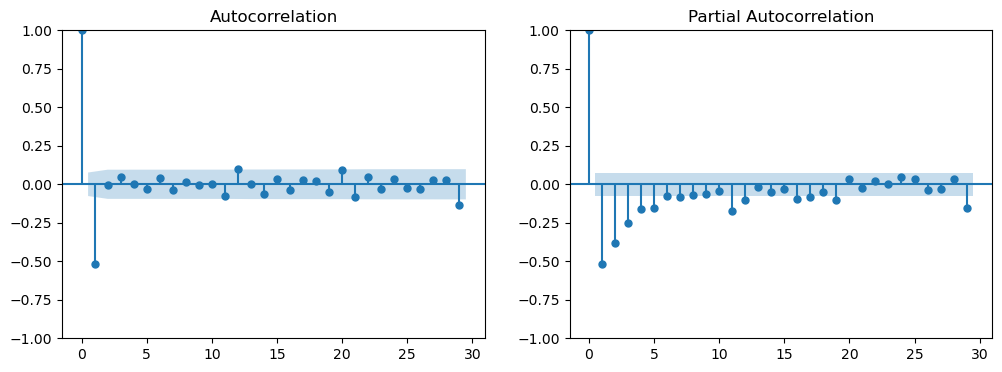

In [271]:
# Plot ACF and PACF to determine ARIMA order
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(time_series_diff, ax=axes[0])
plot_pacf(time_series_diff, ax=axes[1])
plt.show()

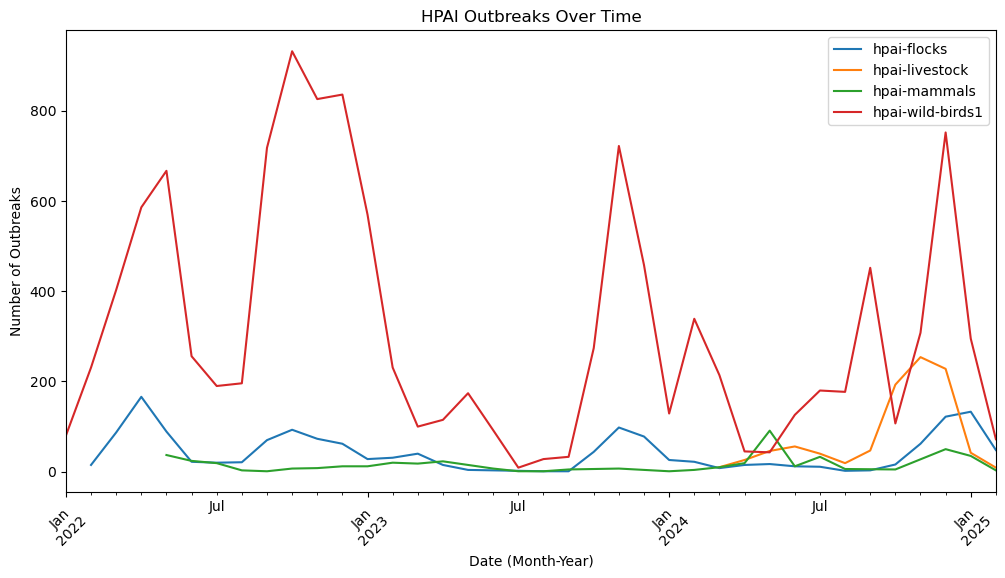

In [ ]:
# 1. HPAI Outbreaks Over Time
plt.figure(figsize=(12, 6))
for name, df in dataframes.items():
    df["Outbreak Date"].dt.to_period("M").value_counts().sort_index().plot(label=name)

plt.title("HPAI Outbreaks Over Time")
plt.xlabel("Date (Month-Year)")
plt.ylabel("Number of Outbreaks")
plt.legend()
plt.xticks(rotation=45)
plt.show()